In [4]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix
from visualization import load_depth, save_pointcloud_csv
import progressbar
from pointcloud_to_voxelmap import pointclouds_to_voxelmap
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json

In [5]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

in_directory = 'images'
base_name = '2018-03-30--04-05-57--208'

In [6]:
rgb_file = '{}/{}.jpg'.format(in_directory, base_name)
json_file = '{}/{}.json'.format(in_directory, base_name)
depth_file = '{}/{}-depth.png'.format(in_directory, base_name)
stencil_file = '{}/{}-stencil.png'.format(in_directory, base_name)

rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
stencil = np.array(Image.open(stencil_file))

with open(json_file, mode='r') as f:
    data = json.load(f)
view_matrix = np.array(data['view_matrix'])
proj_matrix = np.array(data['proj_matrix'])
width = data['width']
height = data['height']

In [7]:
x_min = -1
x_max = 1
y_min = -1
y_max = 1
x_range = 1
y_range = 1
z_meters_min = 1.5
z_meters_max = 50
# z min calc
z_min = proj_matrix @ [1, 1, -z_meters_max, 1]
z_min = z_min[2] / z_min[3]
# z max calc
z_max = proj_matrix @ [1, 1, -z_meters_min, 1]
z_max = z_max[2] / z_max[3]
z_range = 100
x_bin = (x_max - x_min) / x_range
y_bin = (y_max - y_min) / y_range
z_bin = (z_max - z_min) / z_range


In [8]:
X, Y, Z, W = np.mgrid[x_min:x_max:x_bin, y_min:y_max:y_bin, z_min:z_max:z_bin, 1:2:1]  # W is here as homo coordinate
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])


In [9]:
params = {
    'width': width,
    'height': height,
    'proj_matrix': proj_matrix,
}

vecs_p = ndc_to_view(positions, proj_matrix)
#print(vecs_p.shape)
#vecs_p[:, :] /= vecs_p[:, 3]
#vecs_p = vec_p.T


In [ ]:
save_pointcloud_csv(vecs_p.T[:, 0:3], '{}/{}.csv'.format(in_directory, base_name))
save_pointcloud_csv(positions.T[:, 0:3], '{}/ndc-{}.csv'.format(in_directory, base_name))

In [126]:
positions.T[:, 0:3].shape

(250000, 3)

In [156]:
vecs_p.shape

(4, 100)

In [155]:
vecs_p[:, 0:3]

array([[-42.3514997 , -32.00365217, -25.71953423],
       [-23.31538291, -17.61867726, -14.15913942],
       [-50.        , -37.78337531, -30.36437247],
       [  1.        ,   1.        ,   1.        ]])

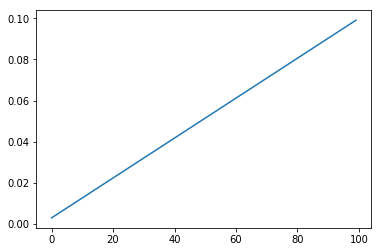

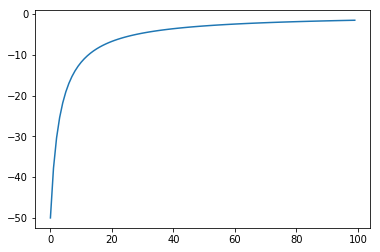

In [159]:
plt.plot(range(Z.shape[2]), positions[2, :])
plt.show()
plt.plot(range(Z.shape[2]), vecs_p[2, :])


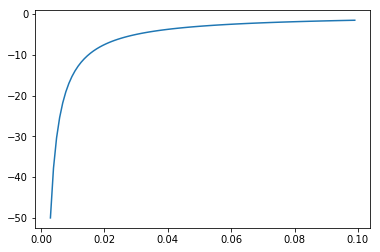

In [161]:
plt.plot(positions[2, :], vecs_p[2, :])

In [160]:
Z[1, 1, :]
range(Z.shape[2])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [168]:
x_min = -10
x_max = 10
y_min = -10
y_max = 10
z_min = -50
z_max = -1.5
x_bin = 0.25  # voxel size
y_bin = 0.25  # voxel size
z_bin = 0.25  # voxel size

X, Y, Z, W = np.mgrid[x_min:x_max:x_bin, y_min:y_max:y_bin, z_min:z_max:z_bin, 1:2:1]  # W is here as homo coordinate
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])


In [169]:
save_pointcloud_csv(positions.T[:, 0:3], '{}/voxel-{}.csv'.format(in_directory, base_name))